开始最终版实验训练...
Step 10000/100000, Loss: 0.009942, Trajectory Error: 7.32e-14
Step 20000/100000, Loss: 0.003959, Trajectory Error: 8.84e-14
Step 30000/100000, Loss: 0.002389, Trajectory Error: 3.70e-14
Step 40000/100000, Loss: 0.001686, Trajectory Error: 6.21e-14
Step 50000/100000, Loss: 0.001293, Trajectory Error: 1.85e-14
Step 60000/100000, Loss: 0.001044, Trajectory Error: 1.75e-13
Step 70000/100000, Loss: 0.000872, Trajectory Error: 2.28e-13
Step 80000/100000, Loss: 0.000747, Trajectory Error: 2.92e-13
Step 90000/100000, Loss: 0.000652, Trajectory Error: 4.03e-13
Step 100000/100000, Loss: 0.000578, Trajectory Error: 4.43e-13

开始绘制所有结果图...
最大轨迹误差 (Max Trajectory Error): 4.4602e-13


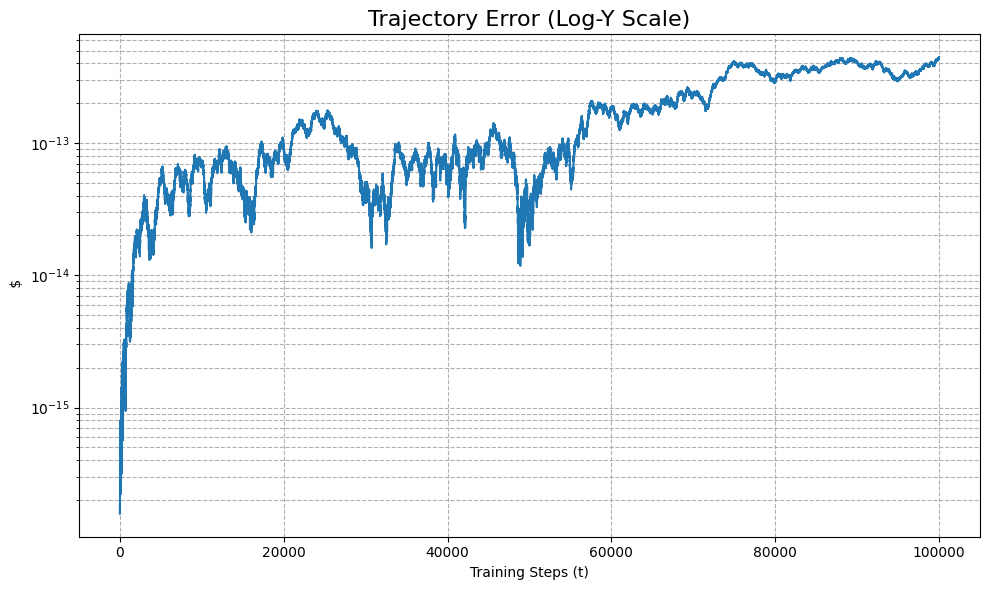

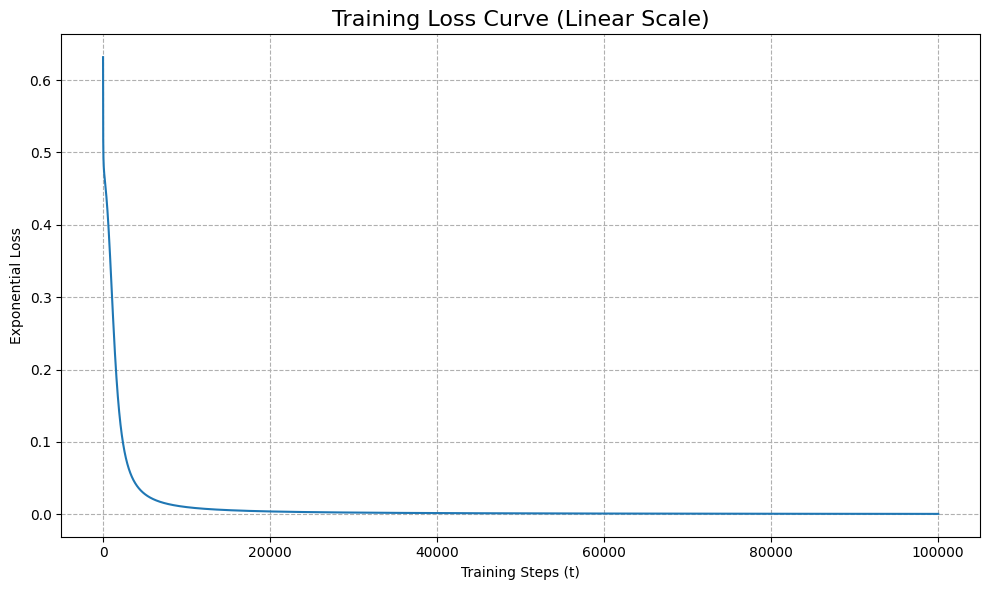

正在绘制决策边界...


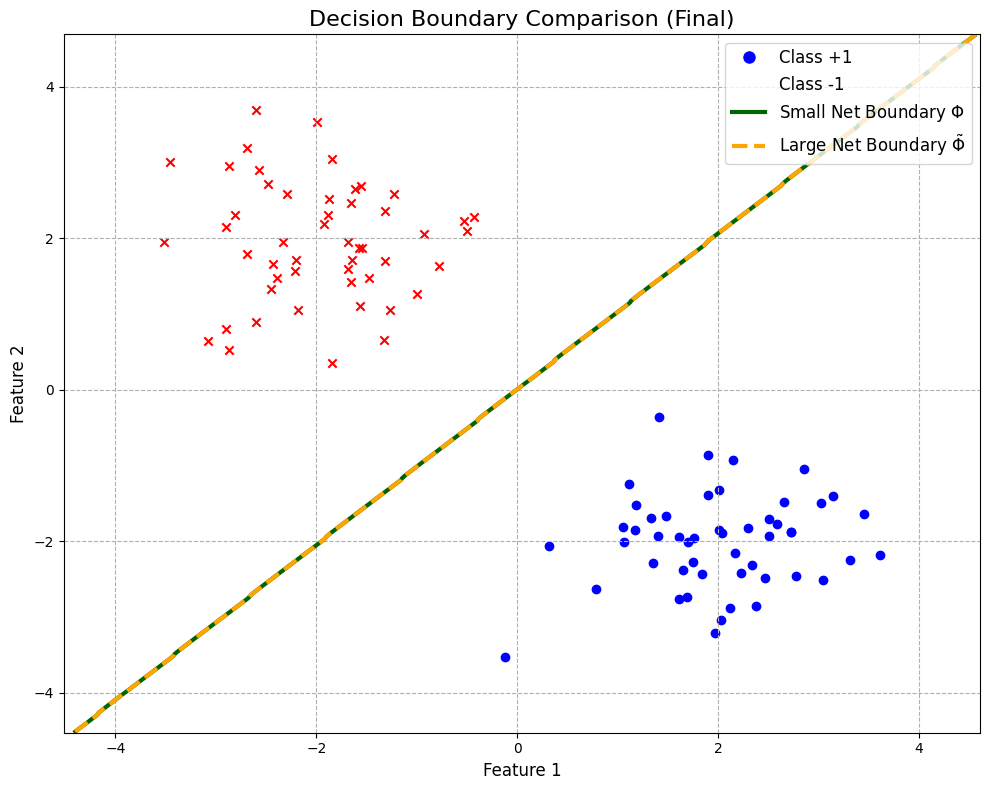

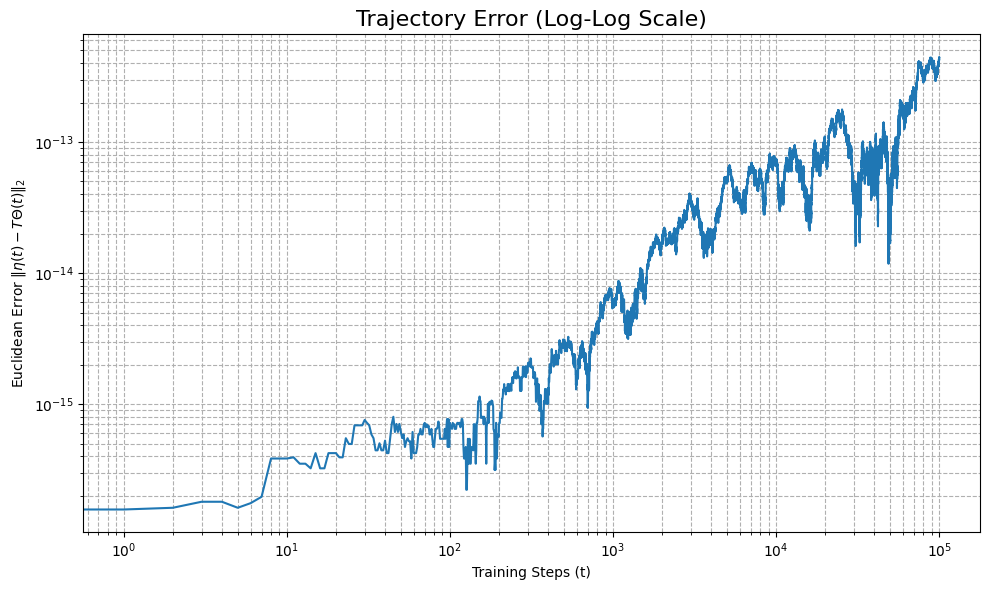

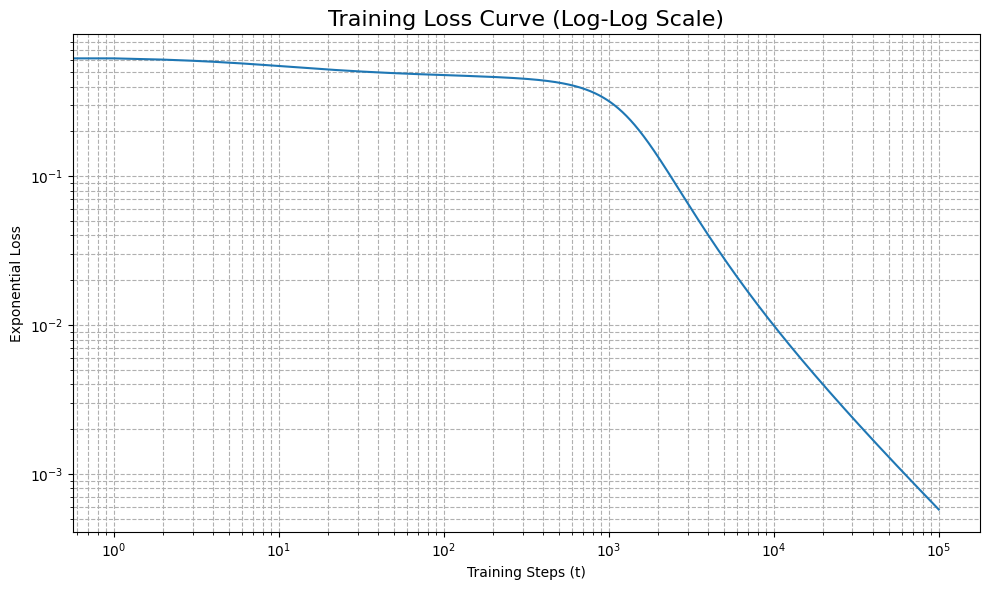

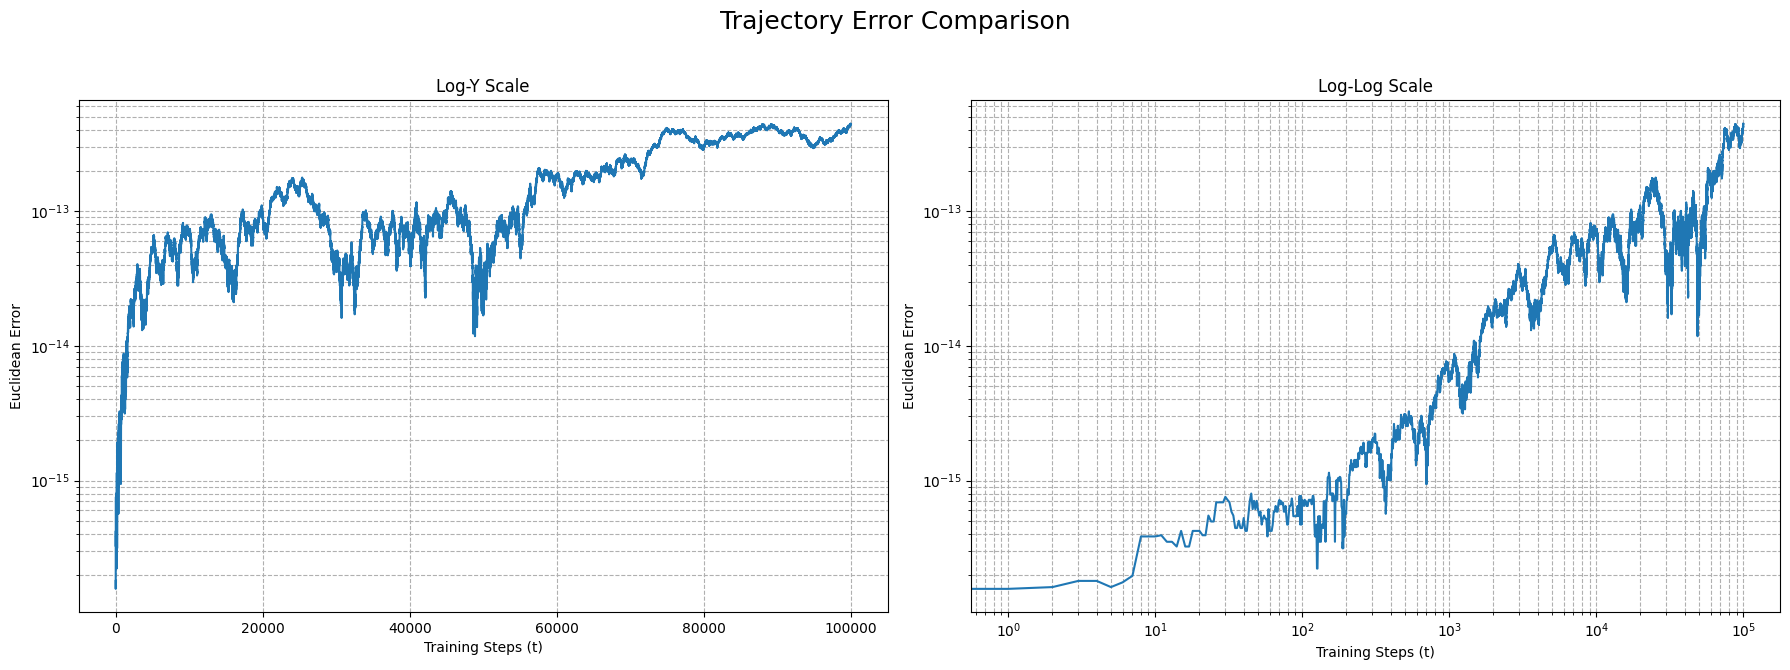

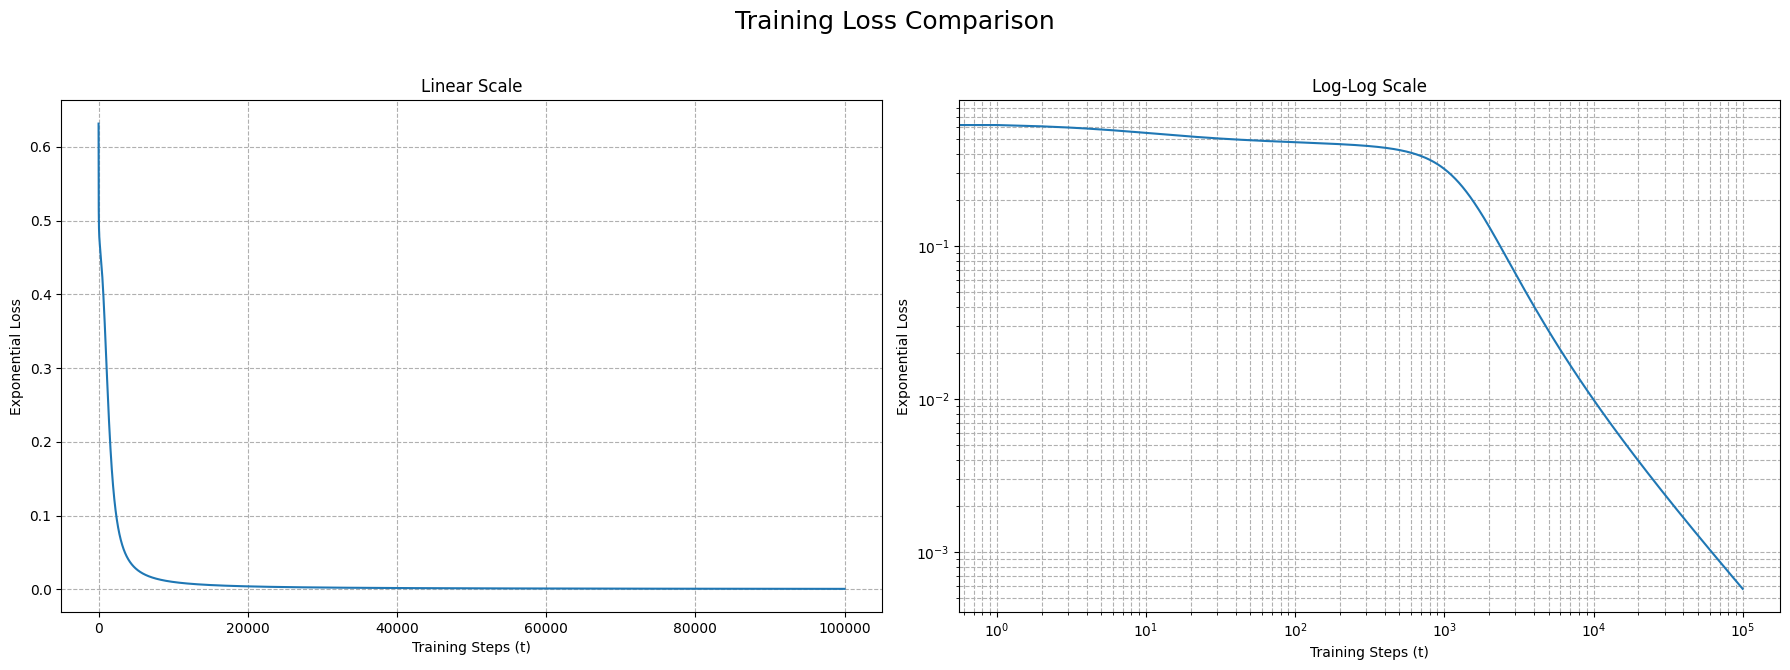


所有7张最终版实验图已生成并保存为PDF。


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Experiment Setup ---
LEARNING_RATE = 0.1 
N_STEPS = 100000

N_SAMPLES = 100
INPUT_DIM = 2
HIDDEN_DIM_SMALL = 1
HIDDEN_DIM_LARGE = 2
OUTPUT_DIM = 1

torch.manual_seed(123)
np.random.seed(123)

# --- 2. Data Generation (using origin-separable data) ---
def generate_origin_separable_data(n_samples=100):
    """
    Generates a new dataset that is perfectly separable by a line passing through the origin.
    """
    dtype = torch.double
    
    # New cluster centers: (2, -2) and (-2, 2)
    center1 = torch.tensor([2.0, -2.0], dtype=dtype)
    center2 = torch.tensor([-2.0, 2.0], dtype=dtype)
    
    X1 = torch.randn(n_samples // 2, 2, dtype=dtype) * 0.8 + center1
    y1 = torch.ones(n_samples // 2, 1, dtype=dtype)
    
    X2 = torch.randn(n_samples // 2, 2, dtype=dtype) * 0.8 + center2
    y2 = -torch.ones(n_samples // 2, 1, dtype=dtype)
    
    X = torch.cat([X1, X2], dim=0)
    y = torch.cat([y1, y2], dim=0)
    return X, y

# --- 3. Model Forward Pass (Leaky ReLU) ---
def leaky_relu(x, negative_slope=0.01):
    return torch.where(x > 0, x, x * negative_slope)

def forward_small(params_small, X):
    W_in, W_out = params_small['W_in'], params_small['W_out']
    hidden = leaky_relu(X @ W_in.T)
    output = hidden @ W_out.T
    return output

def forward_large(params_large, X):
    W_in, W_out = params_large['W_in'], params_large['W_out']
    hidden = leaky_relu(X @ W_in.T)
    output = hidden @ W_out.T
    return output

# --- 4. Mapping T ---
def transform_params(params_small):
    W_in_small, W_out_small = params_small['W_in'], params_small['W_out']
    c1, c2 = 1.0 / np.sqrt(2), 1.0 / np.sqrt(2)
    W_in_large = torch.cat([c1 * W_in_small, c2 * W_in_small], dim=0)
    W_out_large = torch.cat([c1 * W_out_small, c2 * W_out_small], dim=1)
    return {'W_in': W_in_large, 'W_out': W_out_large}

# --- 5. Loss Function ---
def exponential_loss(y_pred, y_true):
    return torch.mean(torch.exp(-y_true * y_pred))

# --- 6. Decision Boundary Visualization ---
def plot_decision_boundary(params_small, params_large, X, y, filename="plot3_decision_boundary_final.pdf"):
    print("Plotting decision boundary...")
    plt.figure(figsize=(10, 8))
    plt.scatter(X[y.flatten() == 1, 0].numpy(), X[y.flatten() == 1, 1].numpy(), c='b', marker='o', label='Class +1')
    plt.scatter(X[y.flatten() == -1, 0].numpy(), X[y.flatten() == -1, 1].numpy(), c='r', marker='x', label='Class -1')
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min.numpy(), x_max.numpy(), 0.02),
                         np.arange(y_min.numpy(), y_max.numpy(), 0.02))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.double)
    with torch.no_grad():
        Z_small = forward_small(params_small, grid).reshape(xx.shape)
        Z_large = forward_large(params_large, grid).reshape(xx.shape)
    
    plt.contour(xx, yy, Z_small, levels=[0], colors='darkgreen', linestyles='-', linewidths=3)
    plt.contour(xx, yy, Z_large, levels=[0], colors='orange', linestyles='--', linewidths=3)
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class +1', markerfacecolor='b', markersize=10),
        Line2D([0], [0], marker='x', color='w', label='Class -1', markerfacecolor='r', markersize=10),
        Line2D([0], [0], color='darkgreen', lw=3, label='Small Net Boundary $\Phi$'),
        Line2D([0], [0], color='orange', lw=3, ls='--', label='Large Net Boundary $\\tilde{\Phi}$')
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    plt.title('Decision Boundary Comparison (Final)', fontsize=16)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# --- 7. Main Training Loop ---
if __name__ == '__main__':
    X, y = generate_origin_separable_data(N_SAMPLES)
    dtype = torch.double

    W_in_s = torch.empty(HIDDEN_DIM_SMALL, INPUT_DIM, dtype=dtype); nn.init.kaiming_uniform_(W_in_s, a=math.sqrt(5))
    W_out_s = torch.empty(OUTPUT_DIM, HIDDEN_DIM_SMALL, dtype=dtype)
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W_out_s); bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0; nn.init.uniform_(W_out_s, -bound, bound)

    params_small = {'W_in': W_in_s.requires_grad_(), 'W_out': W_out_s.requires_grad_()}
    params_large_dict = transform_params(params_small)
    params_large = {
        'W_in': params_large_dict['W_in'].clone().detach().requires_grad_(True),
        'W_out': params_large_dict['W_out'].clone().detach().requires_grad_(True)
    }

    optimizer_small = torch.optim.SGD(params_small.values(), lr=LEARNING_RATE)
    optimizer_large = torch.optim.SGD(params_large.values(), lr=LEARNING_RATE)

    error_history = []
    loss_history = []
    print("Starting the main experiment training...")
    for step in range(N_STEPS):
        optimizer_small.zero_grad(); optimizer_large.zero_grad()
        output_small = forward_small(params_small, X); loss_small = exponential_loss(output_small, y); loss_small.backward(); optimizer_small.step()
        output_large = forward_large(params_large, X); loss_large = exponential_loss(output_large, y); loss_large.backward(); optimizer_large.step()
        
        with torch.no_grad():
            predicted_params_large = transform_params(params_small)
            actual_vec = torch.cat([p.flatten() for p in params_large.values()])
            predicted_vec = torch.cat([p.flatten() for p in predicted_params_large.values()])
            error_history.append(torch.norm(actual_vec - predicted_vec).item())
            loss_history.append(loss_small.item())

        if (step + 1) % 10000 == 0:
            print(f"Step {step+1}/{N_STEPS}, Loss: {loss_small.item():.6f}, Trajectory Error: {error_history[-1]:.2e}")

    # --- 8. Plotting All Results ---
    print("\nPlotting all result figures...")
    max_trajectory_error = max(error_history)
    print(f"Max Trajectory Error: {max_trajectory_error:.4e}")

    # Add "_final" suffix to filenames for distinction.
    
    # --- 5 individual plots ---
    
    plt.figure(figsize=(10, 6)); plt.plot(error_history)
    plt.title('Trajectory Error (Log-Y Scale)', fontsize=16)
    plt.xlabel('Training Steps (t)'); plt.ylabel('Euclidean Error $\|\eta(t) - T\Theta(t)\|_2$')
    plt.yscale('log'); plt.grid(True, which="both", ls="--"); plt.tight_layout()
    plt.savefig("plot1_error_logy_final.pdf"); plt.show()

    plt.figure(figsize=(10, 6)); plt.plot(loss_history)
    plt.title('Training Loss Curve (Linear Scale)', fontsize=16)
    plt.xlabel('Training Steps (t)'); plt.ylabel('Exponential Loss')
    plt.grid(True, which="both", ls="--"); plt.tight_layout()
    plt.savefig("plot2_loss_linear_final.pdf"); plt.show()

    plot_decision_boundary(params_small, params_large, X, y) 

    plt.figure(figsize=(10, 6)); plt.plot(error_history)
    plt.title('Trajectory Error (Log-Log Scale)', fontsize=16)
    plt.xlabel('Training Steps (t)'); plt.ylabel('Euclidean Error $\|\eta(t) - T\Theta(t)\|_2$')
    plt.xscale('log'); plt.yscale('log'); plt.grid(True, which="both", ls="--")
    plt.tight_layout(); plt.savefig("plot4_error_loglog_final.pdf"); plt.show()

    plt.figure(figsize=(10, 6)); plt.plot(loss_history)
    plt.title('Training Loss Curve (Log-Log Scale)', fontsize=16)
    plt.xlabel('Training Steps (t)'); plt.ylabel('Exponential Loss')
    plt.xscale('log'); plt.yscale('log'); plt.grid(True, which="both", ls="--")
    plt.tight_layout(); plt.savefig("plot5_loss_loglog_final.pdf"); plt.show()

    # --- 2 combined comparison plots (side-by-side layout) ---

    # Figure 6: Trajectory Error Comparison (subplots)
    fig, axs = plt.subplots(1, 2, figsize=(18, 7)) # Change to 1 row, 2 columns, adjust figsize
    fig.suptitle('Trajectory Error Comparison', fontsize=18)
    # Subplot 1 (Left): Log-Y
    axs[0].plot(error_history)
    axs[0].set_title('Log-Y Scale')
    axs[0].set_xlabel('Training Steps (t)')
    axs[0].set_ylabel('Euclidean Error')
    axs[0].set_yscale('log')
    axs[0].grid(True, which="both", ls="--")
    # Subplot 2 (Right): Log-Log
    axs[1].plot(error_history)
    axs[1].set_title('Log-Log Scale')
    axs[1].set_xlabel('Training Steps (t)')
    axs[1].set_ylabel('Euclidean Error')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("plot6_error_comparison_final.pdf"); plt.show()

    # Figure 7: Training Loss Comparison (subplots)
    fig, axs = plt.subplots(1, 2, figsize=(18, 7)) # Change to 1 row, 2 columns, adjust figsize
    fig.suptitle('Training Loss Comparison', fontsize=18)
    # Subplot 1 (Left): Linear
    axs[0].plot(loss_history)
    axs[0].set_title('Linear Scale')
    axs[0].set_xlabel('Training Steps (t)')
    axs[0].set_ylabel('Exponential Loss')
    axs[0].grid(True, which="both", ls="--")
    # Subplot 2 (Right): Log-Log
    axs[1].plot(loss_history)
    axs[1].set_title('Log-Log Scale')
    axs[1].set_xlabel('Training Steps (t)')
    axs[1].set_ylabel('Exponential Loss')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].grid(True, which="both", ls="--")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("plot7_loss_comparison_final.pdf"); plt.show()
    
    print("\nAll 7 final experimental figures have been generated and saved as PDF.")